In [2]:
import pickle
import pandas as pd
import pylab as pl
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
import os
import pandas as pd  

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
rng = np.random.default_rng(73512)

In [3]:
path = "data/train.pkl"
with open(path, "rb") as f:
    data = pickle.load(f)

- `list` with 239 elem: 
    - `tuple`:
        - sequence - `array` of `float` 4756x
        - label - `int` 1x

In [4]:
len(data)

2939

In [5]:
data_seq = []
data_targets = []

for sequence, label in data:
    data_seq.append(torch.from_numpy(sequence))
    data_targets.append(label)

data_targets = torch.tensor(data_targets)
data_targets_one_hot = nn.functional.one_hot(data_targets)

In [6]:
min_value = float('inf')
max_value = float('-inf')

for tensor in data_seq:
    tensor_min = tensor.min().item()
    tensor_max = tensor.max().item()
    min_value = min(min_value, tensor_min)
    max_value = max(max_value, tensor_max)

data_seq_scaled = []
for tensor in data_seq:
    scaled_tensor = (tensor - min_value) / (max_value - min_value)
    data_seq_scaled.append(scaled_tensor)

In [7]:
print("check class counts to weight them later if needed")
class_counts = data_targets_one_hot.shape[1] * [0]
for label_one_hot in data_targets_one_hot:
    index_in_one_hot = torch.argmax(label_one_hot).item()
    class_counts[index_in_one_hot] += 1
class_counts

check class counts to weight them later if needed


[1630, 478, 154, 441, 236]

In [8]:
class_counts = torch.tensor(class_counts).to(device)
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / torch.sum(class_weights)
class_weights

tensor([0.0391, 0.1332, 0.4135, 0.1444, 0.2698], device='cuda:0')

In [9]:
class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(x, y) for x, y in zip(in_data, target)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

In [10]:
# pass data_seq_scaled if you want to use scaled data

train_seq, test_seq, train_targets, test_targets = train_test_split(data_seq, data_targets_one_hot, test_size=0.3, random_state=42, stratify=data_targets_one_hot)
train_set = VariableLenDataset(train_seq, train_targets)
test_set = VariableLenDataset(test_seq, test_targets)

In [11]:
print("sanity check if classes are equally distributed")
for i in range(5):
    total = torch.sum(train_targets[:,i])
    print(f"{i}: {total} {total / train_targets[:,i].shape[0]:.3f}")
print()
for i in range(5):
    total = torch.sum(test_targets[:,i])
    print(f"{i}: {total} {total / test_targets[:,i].shape[0]:.3f}")

sanity check if classes are equally distributed
0: 1141 0.555
1: 334 0.162
2: 108 0.053
3: 309 0.150
4: 165 0.080

0: 489 0.554
1: 144 0.163
2: 46 0.052
3: 132 0.150
4: 71 0.080


In [12]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

pad = -1

def pad_collate(batch, pad_value=-1):
    xx, yy = zip(*batch)
    x_lens = torch.tensor([len(x) for x in xx])

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    yy = torch.stack(list(yy), dim=0)

    return xx_pad, yy, x_lens, 1

In [13]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=pad_collate)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, drop_last=False, collate_fn=pad_collate)

In [14]:
print(next(iter(train_loader))[1][0])
num_classes = next(iter(train_loader))[1][0].shape[0]
print(num_classes)

tensor([1, 0, 0, 0, 0])
5


In [15]:
sample_batch = next(iter(train_loader))
(x, y, x_len, y_len) = sample_batch

In [16]:
x.shape, x_len.shape

(torch.Size([64, 2734]), torch.Size([64]))

In [17]:
y.shape, y_len

(torch.Size([64, 5]), 1)

In [68]:
class ComposerClassifier_v1(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, out_size)
    
    def __str__(self) -> str:
        return "ComposerClassifier_v1"

    def forward(self, inputs, lengths):
        packed_seq = pack_padded_sequence(inputs, lengths, batch_first=True, enforce_sorted=False)
        lstm_out, _ = self.lstm(packed_seq)
        unpacked_seq, _ = pad_packed_sequence(lstm_out, batch_first=True)
        
        last_values = unpacked_seq[torch.arange(unpacked_seq.size(0)), lengths-1, :]
        
        output = self.fc(last_values)
        return output

In [69]:
class ComposerClassifier_v2(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super(ComposerClassifier_v2, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.conv = nn.Conv1d(hidden_size, 64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64, out_size)

    def __str__(self) -> str:
        return "ComposerClassifier_v2"
    
    def forward(self, inputs, lengths):
        packed_seq = pack_padded_sequence(inputs, lengths, batch_first=True, enforce_sorted=False)
        
        lstm_out, _ = self.lstm(packed_seq)
        unpacked_seq, _ = pad_packed_sequence(lstm_out, batch_first=True)
        
        unpacked_seq = unpacked_seq.transpose(1, 2)
        
        conv_out = self.conv(unpacked_seq)
        max_pool_out = torch.max_pool1d(conv_out, kernel_size=conv_out.size(2))
        
        max_pool_out = max_pool_out.squeeze(2)
        output = self.fc(max_pool_out)
        
        return output

In [70]:
class ComposerClassifier_v3(nn.Module):

    def __init__(self, input_size, hidden_lstm_size, num_lstm_layers, hidden_fc_size, out_size):
        super().__init__()
        self.num_layers = num_lstm_layers
        self.hidden_size = hidden_lstm_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_lstm_size, num_layers=num_lstm_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_lstm_size, hidden_fc_size)
        self.fc2 = nn.Linear(hidden_fc_size, out_size)
        self.act = nn.ReLU()

    def __str__(self) -> str:
        return "ComposerClassifier_v3"

    def forward(self, inputs, lengths):
        packed_seq = pack_padded_sequence(inputs, lengths, batch_first=True, enforce_sorted=False)
        lstm_out, _ = self.lstm(packed_seq)
        unpacked_seq, _ = pad_packed_sequence(lstm_out, batch_first=True)

        last_values = unpacked_seq[torch.arange(unpacked_seq.size(0)), lengths-1, :]

        out = self.fc1(last_values)
        out = self.act(out)
        out = self.fc2(out)

        return out

In [75]:
def train(model, optimizer, criterion, epoch_num, train_loader, test_loader):
    train_batch_num, test_batch_num = len(train_loader), len(test_loader)
    best_val_acc = 0


    pth_to_save = f"models/{str(model)}"
    if not os.path.exists(pth_to_save):
        os.makedirs(pth_to_save)

    train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = [], [], [], []
    for epoch in range(1, epoch_num + 1): 

        model.train()

        train_progress_bar = tqdm(total=train_batch_num)
        train_progress_bar.set_description(f"Epoch {epoch}: TRAINING")
        loss_sum, correct_sum, sample_num = 0, 0, 0

        for x, targets, x_len, _ in train_loader:
            x = x.to(device).unsqueeze(2)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(x.float(), x_len)
            loss = criterion(outputs, targets.float())
            loss.backward()
            optimizer.step()

            predicted = torch.argmax(outputs, 1)
            labels = torch.argmax(targets, 1)
            
            loss_sum += loss.item()
            correct_sum += (predicted == labels).sum()
            sample_num += len(x)

            train_progress_bar.update(1)

        epoch_loss = loss_sum/train_batch_num
        epoch_accuracy = correct_sum/sample_num

        train_loss_list.append(epoch_loss)
        train_accuracy_list.append(epoch_accuracy)

        train_progress_bar.set_description(f"Epoch {epoch}: TRAINING: epoch loss = {epoch_loss:.2f}, epoch accuracy = {epoch_accuracy:.2f}")
        train_progress_bar.update(1)

        # eval
        model.eval()

        test_progress_bar = tqdm(total=test_batch_num)
        test_progress_bar.set_description(f"Epoch {epoch}: VALIDATION")
        loss_sum, correct_sum, sample_num = 0, 0, 0

        for x, targets, x_len, _ in test_loader:
            x = x.to(device).unsqueeze(2)
            targets = targets.to(device)

            outputs = model(x.float(), x_len)
            loss = criterion(outputs, targets.float())

            predicted = torch.argmax(outputs, 1)
            labels = torch.argmax(targets, 1)

            loss_sum += loss.item()
            correct_sum += (predicted == labels).sum()
            sample_num += len(x)

            test_progress_bar.update(1)

        epoch_loss = loss_sum/test_batch_num
        epoch_accuracy = correct_sum/sample_num

        test_loss_list.append(epoch_loss)
        test_accuracy_list.append(epoch_accuracy)

        if epoch_accuracy > best_val_acc:
            best_val_acc = epoch_accuracy
            torch.save(model.state_dict(), pth_to_save + f"/{epoch}_{epoch_accuracy.item():.3f}.pth")

        test_progress_bar.set_description(f"Epoch {epoch}: VALIDATION: epoch loss = {epoch_loss:.2f}, epoch accuracy = {epoch_accuracy:.2f}")
        test_progress_bar.update(1)
        print()

    return train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list

In [72]:
model = ComposerClassifier_v3(input_size=1, hidden_lstm_size=128, num_lstm_layers=2, hidden_fc_size=256, out_size=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights)
train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = train(model, optimizer, criterion, 100, train_loader, test_loader)

  0%|          | 0/33 [00:00<?, ?it/s]

KeyboardInterrupt: 

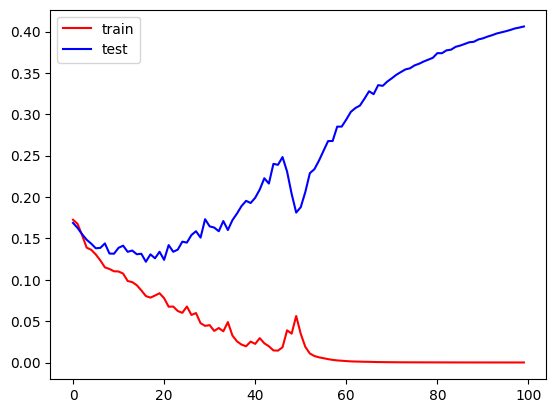

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list, color="r", label="train")
plt.plot(test_loss_list, color="b", label="test")
plt.legend()
plt.show()

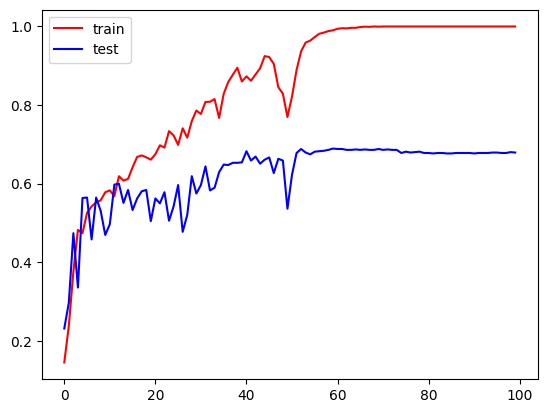

In [ ]:
train_accuracy_list = [x.detach().cpu() for x in train_accuracy_list]
test_accuracy_list = [x.detach().cpu() for x in test_accuracy_list]
plt.plot(train_accuracy_list, color="r", label="train")
plt.plot(test_accuracy_list, color="b", label="test")
plt.legend()
plt.show()

overfitting

In [ ]:
model = ComposerClassifier_v3(input_size=1, hidden_lstm_size=64, num_lstm_layers=2, hidden_fc_size=128, out_size=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights)
train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = train(model, optimizer, criterion, 100, train_loader, test_loader)

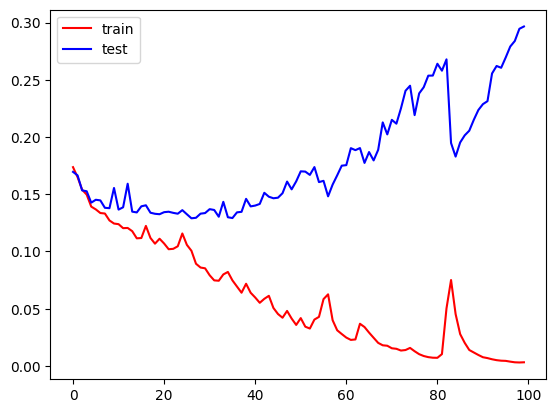

In [ ]:
plt.plot(train_loss_list, color="r", label="train")
plt.plot(test_loss_list, color="b", label="test")
plt.legend()
plt.show()

overfitting

In [ ]:
model = ComposerClassifier_v3(input_size=1, hidden_lstm_size=16, num_lstm_layers=1, hidden_fc_size=16, out_size=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights)
train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = train(model, optimizer, criterion, 100, train_loader, test_loader)

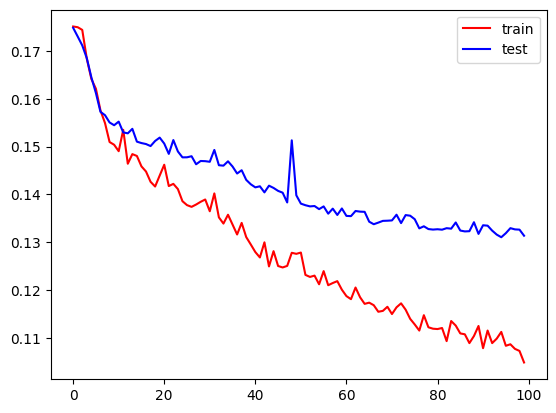

In [ ]:
plt.plot(train_loss_list, color="r", label="train")
plt.plot(test_loss_list, color="b", label="test")
plt.legend()
plt.show()

begining of overfitting

In [ ]:
class ComposerClassifier_v4(nn.Module):

    def __init__(self, input_size, hidden_lstm_size, num_lstm_layers, hidden_fc_size, out_size):
        super().__init__()
        self.num_layers = num_lstm_layers
        self.hidden_size = hidden_lstm_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_lstm_size, num_layers=num_lstm_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_lstm_size * 2, hidden_fc_size)
        self.fc2 = nn.Linear(hidden_fc_size, out_size)
        self.act = nn.ReLU()

    def __str__(self) -> str:
        return "ComposerClassifier_v4"

    def forward(self, inputs, lengths):
        packed_seq = pack_padded_sequence(inputs, lengths, batch_first=True, enforce_sorted=False)
        lstm_out, (hidden, state) = self.lstm(packed_seq)

        hidden, state = torch.squeeze(hidden, 0), torch.squeeze(state, 0)
        lstm_out_cat = torch.cat((hidden, state), 1)

        out = self.fc1(lstm_out_cat)
        out = self.act(out)
        out = self.fc2(out)

        return out

model = ComposerClassifier_v4(input_size=1, hidden_lstm_size=16, num_lstm_layers=1, hidden_fc_size=16, out_size=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights)
train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = train(model, optimizer, criterion, 100, train_loader, test_loader)

  0%|          | 0/33 [00:00<?, ?it/s]

KeyboardInterrupt: 

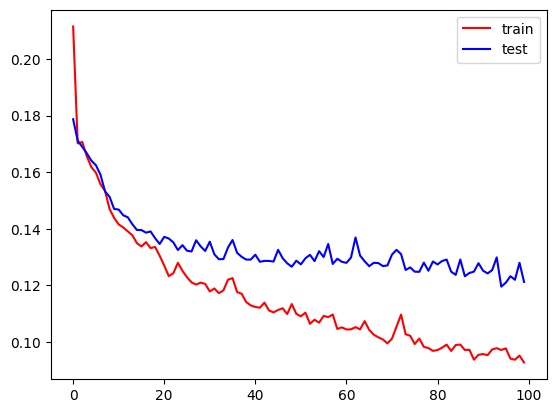

In [ ]:
plt.plot(train_loss_list, color="r", label="train")
plt.plot(test_loss_list, color="b", label="test")
plt.legend()
plt.show()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights)
train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = train(model, optimizer, criterion, 100, train_loader, test_loader)

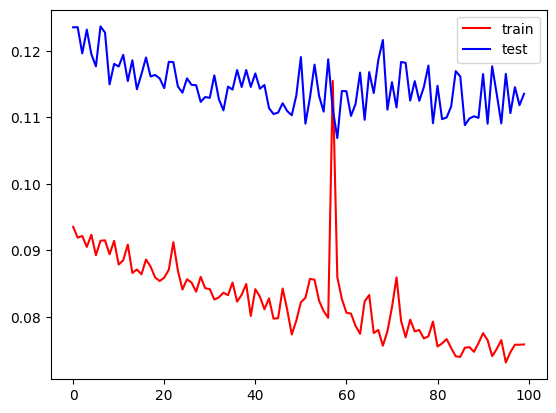

In [ ]:
plt.plot(train_loss_list, color="r", label="train")
plt.plot(test_loss_list, color="b", label="test")
plt.legend()
plt.show()

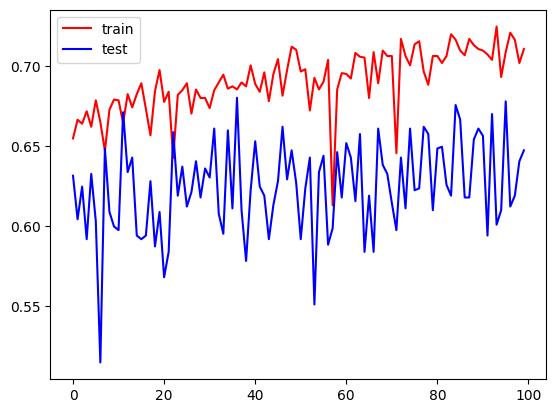

In [ ]:
train_accuracy_list = [x.detach().cpu() for x in train_accuracy_list]
test_accuracy_list = [x.detach().cpu() for x in test_accuracy_list]
plt.plot(train_accuracy_list, color="r", label="train")
plt.plot(test_accuracy_list, color="b", label="test")
plt.legend()
plt.show()

In [ ]:
class ComposerClassifier_v5(nn.Module):

    def __init__(self, input_size, hidden_lstm_size, num_lstm_layers, hidden_fc_size, out_size):
        super().__init__()
        self.num_layers = num_lstm_layers
        self.hidden_size = hidden_lstm_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_lstm_size, num_layers=num_lstm_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_lstm_size * num_lstm_layers * 4, hidden_fc_size)
        self.fc2 = nn.Linear(hidden_fc_size, out_size)
        self.act = nn.ReLU()

    def __str__(self) -> str:
        return "ComposerClassifier_v5"

    def forward(self, inputs, lengths):
        packed_seq = pack_padded_sequence(inputs, lengths, batch_first=True, enforce_sorted=False)
        lstm_out, (hidden, state) = self.lstm(packed_seq)

        lstm_out_cat = torch.cat((hidden, state), 2)
        lstm_out_cat = torch.transpose(lstm_out_cat, 0,1)
        out = torch.flatten(lstm_out_cat, start_dim=1)
        out = self.fc1(out)
        out = self.act(out)
        out = self.fc2(out)

        return out

model = ComposerClassifier_v5(input_size=1, hidden_lstm_size=30, num_lstm_layers=2, hidden_fc_size=30, out_size=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights)
train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = train(model, optimizer, criterion, 100, train_loader, test_loader)

  0%|          | 0/33 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
class ComposerClassifier_v6(nn.Module):

    def __init__(self, input_size, hidden_lstm_size, num_lstm_layers, hidden_fc_size, out_size):
        super().__init__()
        self.num_layers = num_lstm_layers
        self.hidden_size = hidden_lstm_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_lstm_size, num_layers=num_lstm_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_lstm_size * num_lstm_layers * 4, hidden_fc_size)
        self.bn1 = nn.BatchNorm1d(hidden_fc_size)
        self.fc2 = nn.Linear(hidden_fc_size, out_size)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def __str__(self) -> str:
        return "ComposerClassifier_v6"

    def forward(self, inputs, lengths):
        packed_seq = pack_padded_sequence(inputs, lengths, batch_first=True, enforce_sorted=False)
        lstm_out, (hidden, state) = self.lstm(packed_seq)

        lstm_out_cat = torch.cat((hidden, state), 2)
        lstm_out_cat = torch.transpose(lstm_out_cat, 0,1)
        out = torch.flatten(lstm_out_cat, start_dim=1)
        out = self.fc1(out)
        out = self.bn1(out)
        out = self.act(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out

In [19]:
model = ComposerClassifier_v6(input_size=1, hidden_lstm_size=30, num_lstm_layers=2, hidden_fc_size=30, out_size=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [20]:
train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = train(model, optimizer, criterion, 100, train_loader, test_loader)

NameError: name 'train' is not defined

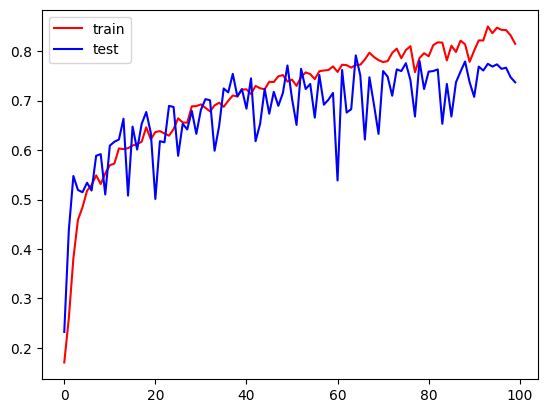

In [77]:
train_accuracy_list = [x.detach().cpu() for x in train_accuracy_list]
test_accuracy_list = [x.detach().cpu() for x in test_accuracy_list]
plt.plot(train_accuracy_list, color="r", label="train")
plt.plot(test_accuracy_list, color="b", label="test")
plt.legend()
plt.show()

In [21]:
model = ComposerClassifier_v6(input_size=1, hidden_lstm_size=30, num_lstm_layers=2, hidden_fc_size=30, out_size=num_classes).to(device)
model.load_state_dict(torch.load("models/ComposerClassifier_v6/65_0.791.pth"))

<All keys matched successfully>

In [22]:
model.eval()

ComposerClassifier_v6(
  (lstm): LSTM(1, 30, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=240, out_features=30, bias=True)
  (bn1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=30, out_features=5, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [30]:
path_target = "data/test_no_target.pkl"
with open(path_target, "rb") as f:
    data_target = pickle.load(f)

In [33]:
len(data_target)

1103

In [47]:
target_data_seq = [torch.from_numpy(seq) for seq in data_target]

In [54]:
class TargetDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], torch.tensor(0)

In [55]:
target_set = TargetDataset(target_data_seq)

In [56]:
target_loader = DataLoader(target_set, batch_size=64, shuffle=False, drop_last=False, collate_fn=pad_collate)

In [58]:
predictions = []

for x, _, x_len, _ in target_loader:
    x = x.to(device).unsqueeze(2)
    targets = targets.to(device)

    outputs = model(x.float(), x_len)

    predicted = torch.argmax(outputs, 1)
    predictions.extend(predicted.tolist())

In [62]:
len(predictions)

1103

In [63]:
from collections import Counter
Counter(predictions)

Counter({2: 44, 0: 652, 1: 182, 3: 112, 4: 113})

In [61]:
df = pd.DataFrame(predictions)
df.to_csv("poniedzialek_Zarzecki_Filipecki.csv", header=False, index=False)